## ライブラリのインポート

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sudachipy import dictionary, tokenizer
from tqdm import tqdm

## データの読み込み

In [3]:
# プロジェクトデータの読み込み
project_df = pd.read_csv("../data/raw/project.csv")
print(f"プロジェクトデータ: {len(project_df)}件")
print(project_df.head())

# ユーザー職歴データの読み込み
user_df = pd.read_csv(
    "../data/raw/user_work_histories.csv",
    usecols=["user_id", "project_name", "description", "role"],
)
print(f"\nユーザー職歴データ: {len(user_df)}件")
print(user_df.head())

プロジェクトデータ: 1000件
   id          name                                        description  \
0   1    旅行予約システム設計  当プロジェクトでは運用保守、テスト、デプロイ、ドキュメント作成、自動テスト導入やインフラ構築...   
1   2    予約管理システム設計  現プロジェクトにおいてデータベース設計やデプロイなどに取り組んでいる。\n[実施内容]\nデ...   
2   3  ブロックチェーン開発実装  要件定義、要件分析、パフォーマンス改善、自動テスト導入、クラウド移行やセキュリティ強化などの...   
3   4    動画配信サービス改善  技術選定、UI/UX設計、セキュリティ強化、実装、デプロイやデータベース設計などの開発に取り...   
4   5    物流管理システム改善             データベース設計、運用保守やチームマネジメントなどの開発に取り組んでいます。   

  desired_role  start_date end_date  HTML  CSS  JavaScript  TypeScript  ...  \
0      QAエンジニア  2024-04-09      NaN     0    0           0           0  ...   
1  フルスタックエンジニア  2024-12-22      NaN     1    1           1           1  ...   
2  フルスタックエンジニア  2025-05-20      NaN     1    1           1           0  ...   
3    インフラエンジニア  2024-11-24      NaN     0    0           0           0  ...   
4           SE  2024-02-22      NaN     0    0           0           0  ...   

   GCP  Docker  Kubernetes  MySQL  PostgreSQL  MongoDB  Git  Li

## 名詞抽出関数の定義

In [4]:
def extract_nouns(text: str):
    """
    テキストから名詞を抽出する関数
    """
    if pd.isna(text):
        return []

    # full辞書を使用して辞書オブジェクトを生成
    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    # 形態素解析の粒度設定(C: 最も粗い)
    mode = tokenizer.Tokenizer.SplitMode.C

    # 形態素解析を実行
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        # 品詞情報を取得
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns


# 動作確認
sample_text = "AWSを使ったWebアプリケーション開発プロジェクト"
print(f"サンプルテキスト: {sample_text}")
print(f"抽出された名詞: {extract_nouns(sample_text)}")

サンプルテキスト: AWSを使ったWebアプリケーション開発プロジェクト
抽出された名詞: ['AWS', 'Web', 'アプリケーション', '開発', 'プロジェクト']


## Word2Vec用のコーパス作成

In [5]:
def create_corpus_from_df(df, columns, desc="Processing"):
    """
    DataFrameから指定列のテキストを抽出し、名詞のみのリストのリストを作成

    Parameters:
    -----------
    df : pd.DataFrame
        対象のDataFrame
    columns : list
        テキスト抽出対象の列名リスト
    desc : str
        進行状況バーの説明文

    Returns:
    --------
    corpus : list of list
        各行の名詞リスト
    """
    corpus = [] # コーパスを初期化（名詞リストのリスト）

    # DataFrameの各行をループ処理し、進行状況バーを表示
    for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        row_nouns = [] # 現在の行から抽出された名詞を格納するリスト
        # 指定された各列をループ
        for col in columns:
            # 列が存在し、かつ値がNaNでない場合のみ処理
            if col in df.columns and pd.notna(row[col]):
                # テキストから名詞を抽出し、現在の行の名詞リストに追加
                nouns = extract_nouns(str(row[col]))
                row_nouns.extend(nouns)

        # 現在の行から名詞が抽出された場合のみ、コーパスに追加
        if row_nouns:
            corpus.append(row_nouns)

    return corpus # 生成されたコーパスを返す


# プロジェクトデータのコーパスを作成
print("プロジェクトデータの処理中...")
project_columns = ["name", "description", "desired_role"]
project_corpus = create_corpus_from_df(
    project_df, project_columns, desc="プロジェクトデータ"
)

# ユーザー職歴のコーパスを作成
print("\nユーザー職歴データの処理中...")
user_columns = ["project_name", "description", "role"]
user_corpus = create_corpus_from_df(user_df, user_columns, desc="ユーザー職歴データ")

# 両方を結合
corpus = project_corpus + user_corpus

print(f"\n✓ プロジェクトデータコーパス: {len(project_corpus)}件")
print(f"✓ ユーザー職歴コーパス: {len(user_corpus)}件")
print(f"✓ 結合コーパス: {len(corpus)}件")

print("\n【プロジェクトデータ】最初の2件のサンプル:")
for i, doc in enumerate(project_corpus[:2]):
    print(f"{i + 1}: {doc[:15]}...")

print("\n【ユーザー職歴データ】最初の2件のサンプル:")
for i, doc in enumerate(user_corpus[:2]):
    print(f"{i + 1}: {doc[:15]}...")

プロジェクトデータの処理中...


プロジェクトデータ: 100%|██████████| 1000/1000 [00:41<00:00, 23.86it/s]



ユーザー職歴データの処理中...


ユーザー職歴データ: 100%|██████████| 911/911 [00:36<00:00, 25.12it/s]


✓ プロジェクトデータコーパス: 1000件
✓ ユーザー職歴コーパス: 911件
✓ 結合コーパス: 1911件

【プロジェクトデータ】最初の2件のサンプル:
1: ['旅行', '予約', 'システム設計', 'プロジェクト', '運用', '保守', 'テスト', 'デプロイ', 'ドキュメント', '作成', '自動', 'テスト', '導入', 'インフラ', '構築']...
2: ['予約', '管理', 'システム設計', 'プロジェクト', 'データベース設計', 'デプロイ', '実施', '内容', 'データベース設計', 'デプロイ', '実装', '自動', 'テスト', '導入', '運用']...

【ユーザー職歴データ】最初の2件のサンプル:
1: ['スマホアプリ', '開発', 'SNS', 'アプリ', '開発', '担当', 'ドキュメント', '作成', 'テスト', '実施', 'インフラ', '構築', '技術', '検証', 'プログラマー']...
2: ['医療情報システム', '開発', 'オンプレミス', '環境', 'AWS', 'クラウド', '移行', '主導', '新技術', '調査', 'PoC', 'アーキテクチャ', '改善', '提案', 'バックエンド']...


## コーパスをテキストファイルに保存

In [7]:
# コーパスをテキストファイルに保存
save_path_txt = "../data/processed/corpus.txt"
with open(save_path_txt, "w", encoding="utf-8") as f:
    for doc in corpus:
        f.write(" ".join(doc) + "\n")
print(f"コーパスをテキストファイルに保存しました: {save_path_txt}")

コーパスをテキストファイルに保存しました: ../data/processed/corpus.txt


## コーパスの統計情報

In [ ]:
# 全単語の頻度を集計
all_words = [word for doc in corpus for word in doc]
word_freq = Counter(all_words)

print(f"総単語数: {len(all_words):,}")
print(f"ユニーク単語数: {len(word_freq):,}")

print("\n頻出単語 上位30:")
for i, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{i:2d}. {word}: {count:,}回")

総単語数: 34,498
ユニーク単語数: 195

頻出単語 上位30:
 1. 開発: 1,116回
 2. 構築: 1,026回
 3. 設計: 993回
 4. プロジェクト: 892回
 5. テスト: 870回
 6. 担当: 805回
 7. 改善: 739回
 8. 実装: 634回
 9. エンジニア: 546回
10. レビュー: 525回
11. クラウド: 510回
12. 導入: 498回
13. チーム: 492回
14. UI: 484回
15. UX: 484回
16. 技術: 474回
17. システム設計: 415回
18. セキュリティ: 415回
19. 移行: 413回
20. 要件: 404回
21. パフォーマンス: 388回
22. マネジメント: 388回
23. リファクタリング: 381回
24. データベース設計: 369回
25. 要件定義: 369回
26. アーキテクチャ: 341回
27. アプリ: 333回
28. 運用: 327回
29. 強化: 327回
30. 保守: 321回


## Word2Vecモデルの学習

In [ ]:
# Word2Vecモデルの学習
model = Word2Vec(
    sentences=corpus,  # 学習データ
    vector_size=100,  # ベクトルの次元数
    window=5,  # コンテキストウィンドウのサイズ
    min_count=2,  # 最小出現回数（これ以下の単語は無視）
    sg=1,  # 0: CBOW, 1: Skip-gram
    epochs=100,  # エポック数
    negative=5,  # ネガティブサンプリング数（Skip-gram使用時）
    alpha=0.025,  # 初期学習率
    min_alpha=0.0001,  # 最小学習率
    seed=42,  # 再現性のため
)

print(f"語彙数: {len(model.wv):,}語")
print(f"ベクトルの次元数: {model.wv.vector_size}")
print("学習完了")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


語彙数: 195語
ベクトルの次元数: 100
学習完了


## モデルの保存

In [ ]:
# モデルの保存
model.save("../models/word2vec_model.bin")
print("モデルを保存しました: ../models/word2vec_model.bin")

# 単語ベクトルのみを保存（より軽量）
model.wv.save("../models/word2vec_vectors.kv")
print("単語ベクトルを保存しました: ../models/word2vec_vectors.kv")

モデルを保存しました: ../models/word2vec_model.bin
単語ベクトルを保存しました: ../models/word2vec_vectors.kv


## 単語ベクトルの確認

In [ ]:
# 単語ベクトルの確認
test_words = ["開発", "システム", "AWS", "React", "Python", "設計", "テスト"]

print("単語ベクトルの確認:")
for word in test_words:
    if word in model.wv:
        vector = model.wv[word]
        print(f"\n単語: {word}")
        print(f"  ベクトル (最初の10次元): {vector[:10]}")
        print(f"  ベクトルの形状: {vector.shape}")
    else:
        print(f"\n単語 '{word}' は語彙に含まれていません")

単語ベクトルの確認:

単語: 開発
  ベクトル (最初の10次元): [-0.02789855 -0.12265363 -0.20454225 -0.04799237 -0.00489633  0.11165993
 -0.3159436   0.2906913  -0.335178    0.22525175]
  ベクトルの形状: (100,)

単語: システム
  ベクトル (最初の10次元): [ 3.3927950e-01  1.4903598e-01 -6.5555081e-02  8.8786554e-01
 -5.3228334e-02 -1.2942569e-01 -5.4024160e-02  4.3292621e-01
  2.8838387e-01  8.8184013e-04]
  ベクトルの形状: (100,)

単語: AWS
  ベクトル (最初の10次元): [ 0.2371819  -0.09479797 -0.81577456 -0.4187684  -0.28951457  0.5151476
 -0.5931788  -0.13481146 -0.6641909  -0.07309808]
  ベクトルの形状: (100,)

単語: React
  ベクトル (最初の10次元): [ 0.6942052  -0.20396943 -1.0974405   0.32885543 -0.07080424  0.42667228
 -0.26121482 -0.45936072 -0.05295999 -0.39708224]
  ベクトルの形状: (100,)

単語 'Python' は語彙に含まれていません

単語: 設計
  ベクトル (最初の10次元): [-0.08684114  0.04029475 -0.12092648  0.21815157  0.24740705  0.20463087
  0.05213442  0.3897273  -0.09818899  0.06520111]
  ベクトルの形状: (100,)

単語: テスト
  ベクトル (最初の10次元): [-0.16439024 -0.16718015 -0.17005582 -0.07376366  0.30293658  0.3

## 類似単語の検索

In [ ]:
# 類似単語の検索
test_words = ["AWS", "React", "リーダー", "開発", "テスト"]

for test_word in test_words:
    if test_word in model.wv:
        similar_words = model.wv.most_similar(test_word, topn=10)
        print(f"\n'{test_word}' に類似する単語:")
        for word, similarity in similar_words:
            print(f"  {word}: {similarity:.4f}")
    else:
        print(f"\n単語 '{test_word}' は語彙に含まれていません")


'AWS' に類似する単語:
  主導: 0.6118
  オンプレミス: 0.5992
  環境: 0.5638
  新技術: 0.4799
  調査: 0.4697
  課題: 0.4636
  パイプライン: 0.4546
  スクラム: 0.4545
  ユーザビリティテスト: 0.4464
  設定: 0.4455

'React' に類似する単語:
  SPA: 0.6365
  Vue: 0.6112
  アジャイル: 0.4879
  環境: 0.4800
  ユーザビリティテスト: 0.4656
  チームメンバー: 0.4588
  手法: 0.4575
  A: 0.4560
  新技術: 0.4539
  オンプレミス: 0.4521

'リーダー' に類似する単語:
  SE: 0.5503
  PM: 0.5383
  デザイナー: 0.4807
  QA: 0.4379
  インフラエンジニア: 0.4316
  システムエンジニア: 0.4127
  プログラマー: 0.3863
  テスター: 0.3840
  SWE: 0.3747
  マネージャ: 0.3746

'開発' に類似する単語:
  レビュー: 0.4247
  要件定義: 0.3897
  動画配信サービス: 0.3791
  ECサイト: 0.3428
  アプリ: 0.3293
  データ分析: 0.3198
  データベース設計: 0.3186
  リニューアル: 0.3133
  業務効率化: 0.3100
  ツール: 0.3065

'テスト' に類似する単語:
  UX: 0.4513
  UI: 0.4292
  要件定義: 0.4127
  保守: 0.3595
  顧客管理: 0.3272
  コーディング: 0.3213
  リファクタリング: 0.3175
  運用: 0.3075
  分析: 0.3062
  移行: 0.3025


## 単語間の類似度計算

In [ ]:
# 単語間の類似度を計算
word_pairs = [
    ("AWS", "GCP"),
    ("React", "Vue"),
    ("開発", "構築"),
    ("設計", "実装"),
    ("プログラミング", "開発"),
    ("テスト", "デバッグ"),
]

print("単語間の類似度:")
for word1, word2 in word_pairs:
    if word1 in model.wv and word2 in model.wv:
        similarity = model.wv.similarity(word1, word2)
        print(f"  {word1} - {word2}: {similarity:.4f}")
    else:
        missing = []
        if word1 not in model.wv:
            missing.append(word1)
        if word2 not in model.wv:
            missing.append(word2)
        print(f"  {word1} - {word2}: 語彙に含まれていない単語: {', '.join(missing)}")

単語間の類似度:
  AWS - GCP: 語彙に含まれていない単語: GCP
  React - Vue: 0.6112
  開発 - 構築: 0.2403
  設計 - 実装: 0.3745
  プログラミング - 開発: 0.2238
  テスト - デバッグ: 0.0605


## 単語ベクトルをCSVに保存

In [ ]:
# 全単語のベクトルをDataFrameに変換して保存
word_vectors_df = pd.DataFrame(
    [model.wv[word] for word in model.wv.index_to_key], index=model.wv.index_to_key
)

# CSVに保存
word_vectors_df.to_csv("../models/word_vectors.csv")
print("単語ベクトルをCSVに保存しました: ../models/word_vectors.csv")
print(f"形状: {word_vectors_df.shape}")
print("\n最初の5単語:")
print(word_vectors_df.head())

単語ベクトルをCSVに保存しました: ../models/word_vectors.csv
形状: (195, 100)

最初の5単語:
              0         1         2         3         4         5         6   \
開発     -0.027899 -0.122654 -0.204542 -0.047992 -0.004896  0.111660 -0.315944   
構築     -0.101107 -0.081894  0.076581 -0.338300 -0.084593 -0.214634  0.000436   
設計     -0.086841  0.040295 -0.120926  0.218152  0.247407  0.204631  0.052134   
プロジェクト -0.294890  0.003381 -0.329129 -0.001979 -0.059198 -0.299108 -0.272938   
テスト    -0.164390 -0.167180 -0.170056 -0.073764  0.302937  0.355498  0.198790   

              7         8         9   ...        90        91        92  \
開発      0.290691 -0.335178  0.225252  ...  0.234145 -0.050205  0.187062   
構築      0.094284  0.149501 -0.246139  ...  0.019997 -0.041381  0.124765   
設計      0.389727 -0.098189  0.065201  ...  0.007915 -0.194538  0.035403   
プロジェクト  0.298046 -0.297556 -0.210500  ... -0.076616 -0.081113 -0.029177   
テスト    -0.026154  0.006682 -0.148329  ... -0.245260  0.066818 -0.122430   

## t-SNEによる単語ベクトルの可視化

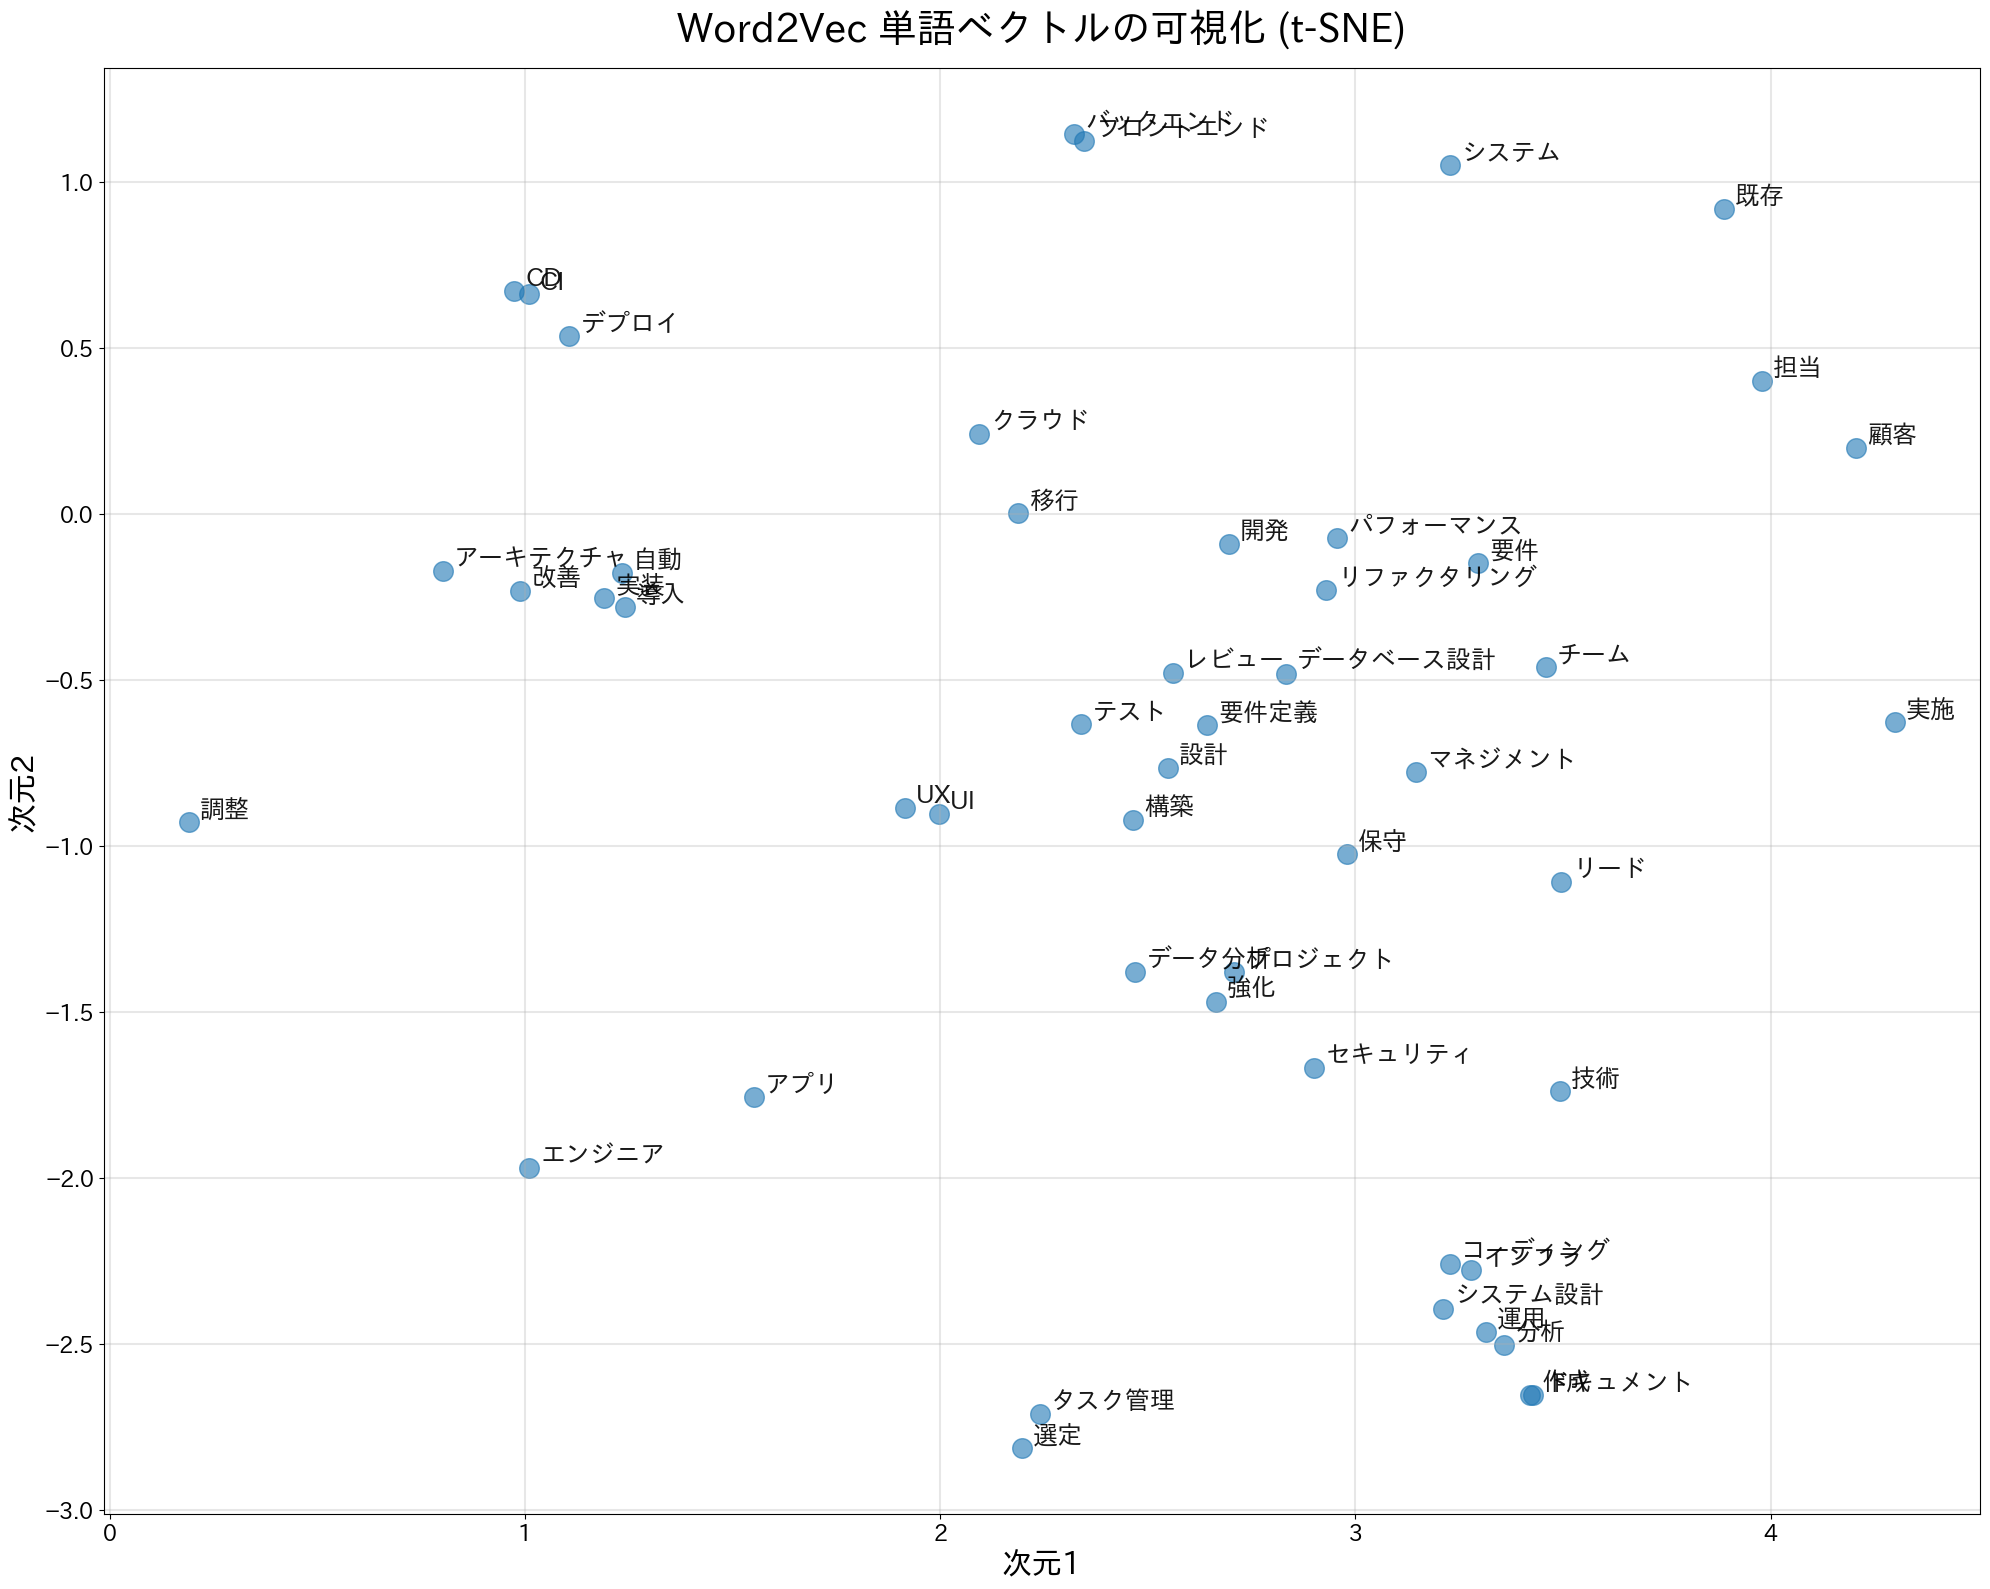

可視化した単語数: 50


In [ ]:
# 頻出単語上位50件を可視化
top_words = [word for word, _ in word_freq.most_common(50)]
top_words_in_model = [word for word in top_words if word in model.wv]

# ベクトルを取得
vectors = np.array([model.wv[word] for word in top_words_in_model])

# t-SNEで2次元に圧縮
tsne = TSNE(
    n_components=2, random_state=42, perplexity=min(30, len(top_words_in_model) - 1)
)
vectors_2d = tsne.fit_transform(vectors)

# 可視化
plt.figure(figsize=(20, 16))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=200)

# 単語ラベルを追加
for i, word in enumerate(top_words_in_model):
    plt.annotate(
        word,
        xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
        xytext=(8, 4),
        textcoords="offset points",
        fontsize=18,
        fontweight="bold",
        alpha=0.9,
    )

plt.title(
    "Word2Vec 単語ベクトルの可視化 (t-SNE)", fontsize=28, fontweight="bold", pad=20
)
plt.xlabel("次元1", fontsize=22, fontweight="bold")
plt.ylabel("次元2", fontsize=22, fontweight="bold")
plt.tick_params(labelsize=16)
plt.grid(True, alpha=0.3, linewidth=1.5)
plt.tight_layout()
plt.show()

print(f"可視化した単語数: {len(top_words_in_model)}")